# Conversion Rate
## Goal
Optimizing conversion rate is likely the most common work of a data scientist. The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don’t. This gives us a tremendous opportunity to understand what’s working well (and potentially scale it even further) and what’s not working well (and fix it).

The goal of this project is to:
* Build a model to predict conversion rate.
* Come up with recommendations for the product team and the marketing team to improve conversion rate.

## Data
We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).
* country: user country based on the IP address.
* age: user age (self-reported at sign-up step).
* new_user: whether the user created the account during this session or had already an account.
* source: marketing channel source.
    * Ads: came to the site by clicking on an advertisement.
    * Seo: came to the site by clicking on search results.
    * Direct: came to the site by directly typing the URL on the browser.
* total_pages_visited: number of total pages visited during the session.
* converted: 1 means users converted within the session, 0 means they left without buying anything.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DF = pd.read_csv('https://drive.google.com/uc?export=download&id=1LU5be_H1TD2Pp1OmI202to3YyKo9AzFY')
DF.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [2]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


## Descriptive Stats
* Conversion rate is around 3%.

In [3]:
round(DF['converted'].mean(), 2)

0.03

* Spending more time on the site implies higher probability of conversion.

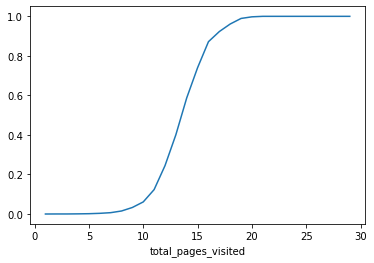

In [4]:
DF.groupby('total_pages_visited')['converted'].mean().plot()

* The majority of the users are in US, followed by China.

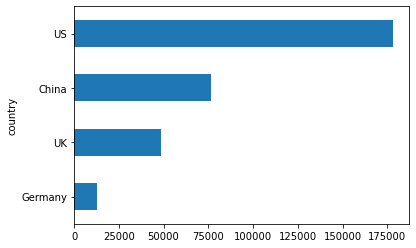

In [5]:
DF.groupby('country').size().sort_values().plot(kind='barh')

* China has a much lower conversion rate than other countries.

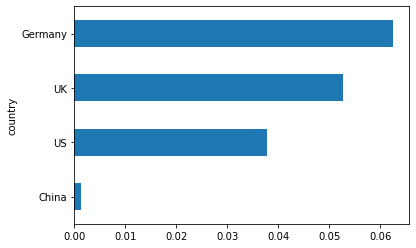

In [6]:
DF.groupby('country')['converted'].mean().sort_values().plot(kind='barh')

* User base is pretty young.

In [7]:
DF['age'].describe()

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

* Age 123 and 111 seem unrealistic. Since there are only 2 users, we can drop them. However, those data can be an indicator of bugs. When working, we might want to talk to the software engineer who implemented the logging code to see if there are bugs which affect the data significantly.

In [8]:
sorted(DF['age'].unique(), reverse = True)[:5]

[123, 111, 79, 77, 73]

In [9]:
DF[DF['age'] >= 111]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [10]:
DF = DF[DF['age'] < 111]

## Machine Learning
Build a model to predict conversion rate, which is binary, and we could choose from:
* Logistic regression
* Decision Trees
* Random Forest or Boosted Decision Trees with partial dependence plots
* RuleFit

Ex: We will pick random forest to predict conversion rate because it usually requires little time to optimize (its default parameters are often close to the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables. We will then use feature importance and partial dependence plots to draw insights, and build a simple decision tree to find the most obvious user segments.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
np.random.seed(4684)

# create dummy variables for categorical variables
DF_dummy = pd.get_dummies(DF, drop_first = True)

# split into train and test with a standard 66% split (if the data are too small, we would cross validate)
train, test = train_test_split(DF_dummy, test_size=0.34)

# build model with 100 trees and 3 random variables selected at each split
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])

RandomForestClassifier(max_features=3, oob_score=True)

* We are confident we are not overfitting as OOB accuracy and test acuuracy are similar ~98.5%. Error is low, but we start from a 97% accuracy (if everything is classified as “not converted”). 
* ~30% of conversions are predicted as “not converted”. But since we care more about drawing insights than finding best accuracy or minimizing false positive/false negative, we are fine with the default 0.5 cutoff value used by random forest.

In [12]:
# OOB accuracy
rf.oob_score_

0.9838851885571901

In [13]:
# OOB confusion matrix
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round()))

,0,1
0,200872,1102
1,2261,4455


In [14]:
# test accuracy
rf.score(test.drop('converted', axis=1), test['converted'])

0.9847360196450496

In [15]:
# test confusion matrix
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1))))

,0,1
0,103483,543
1,1098,2384


* Feature importance: 'total_pages_visted' is the most important variable. However, it is probably the least 'actionable'. People visit many pages because they have to click through multiple pages in order to buy.

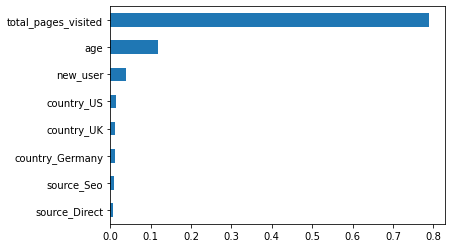

In [16]:
ftImportance = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
ftImportance.sort_values().plot(kind='barh')

* Rebuild random forest without 'total_pages_visted' and change the weights since classes are heavily unbalanced and we don’t have that powerful variable anymore. Accuracy goes down, but the model is good enough to give us insights.

In [17]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [18]:
# OOB accuracy
rf.oob_score_

0.889827016148354

In [19]:
# OOB confusion matrix
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round()))

,0,1
0,182720,19254
1,3738,2978


In [20]:
# test accuracy
rf.score(test.drop(['converted', 'total_pages_visited'], axis=1), test['converted'])

0.8899802805372623

In [21]:
# test confusion matrix
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1))))

,0,1
0,94140,9886
1,1942,1540


* Feature importance: 'new_user' is the most important variable, even more important than 'age' given that continuous variables tend to show up at the top more often. Source related dummies don’t seem to matter much.

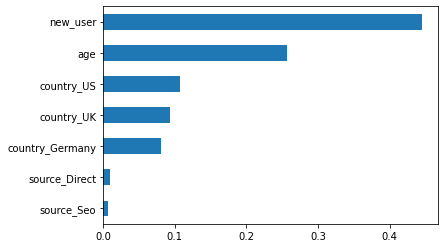

In [22]:
ftImportance = pd.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
ftImportance.sort_values().plot(kind='barh')

* Partial dependence plot (PDP) can compare models or see how model predictions partially depend on input variables. Individaul conditional expectation (ICE) unpack PDP which averages differences among individual/grouped observations.
    * Old users have much high conversion than new users.
    * Young people have higher conversion than people over 30 years old.
    * In contrast to the reference level China, which has low conversion, UK, Germany and US have similar conversion with Germany being the highest.

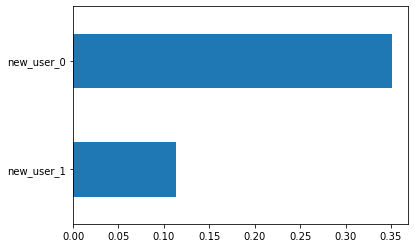

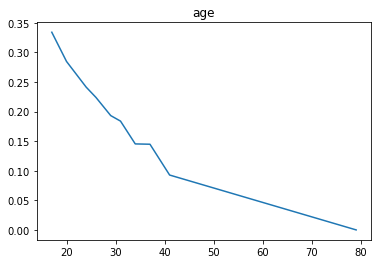

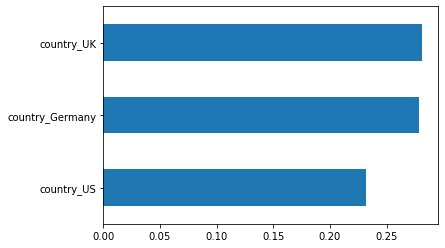

In [23]:
from pdpbox import pdp, info_plots
for i in ['new_user', 'age', ['country_Germany', 'country_UK', 'country_US']]:
    pdp_iso = pdp.pdp_isolate(model=rf,
                              dataset=train.drop(['converted', 'total_pages_visited'], axis=1),
                              model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)),
                              feature=i)
    if i == 'age': pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids).sort_values().plot(title = i)
    else: pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns).sort_values().plot(kind='barh')
    plt.show()

* Build a simple decision tree and check the most important user segments to confirm findings from random forest.

[Text(1860.0, 2013.3333333333333, 'new_user <= 0.5\ngini = 0.375\nsamples = 208690\nvalue = [201974, 67160]'),
 Text(930.0, 1208.0, 'age <= 31.5\ngini = 0.492\nsamples = 65784\nvalue = [61068, 47160]'),
 Text(465.0, 402.6666666666665, 'gini = 0.499\nsamples = 38254\nvalue = [34560, 36940]'),
 Text(1395.0, 402.6666666666665, 'gini = 0.402\nsamples = 27530\nvalue = [26508, 10220]'),
 Text(2790.0, 1208.0, 'age <= 23.5\ngini = 0.218\nsamples = 142906\nvalue = [140906, 20000]'),
 Text(2325.0, 402.6666666666665, 'gini = 0.332\nsamples = 31452\nvalue = [30635, 8170]'),
 Text(3255.0, 402.6666666666665, 'gini = 0.175\nsamples = 111454\nvalue = [110271, 11830]')]

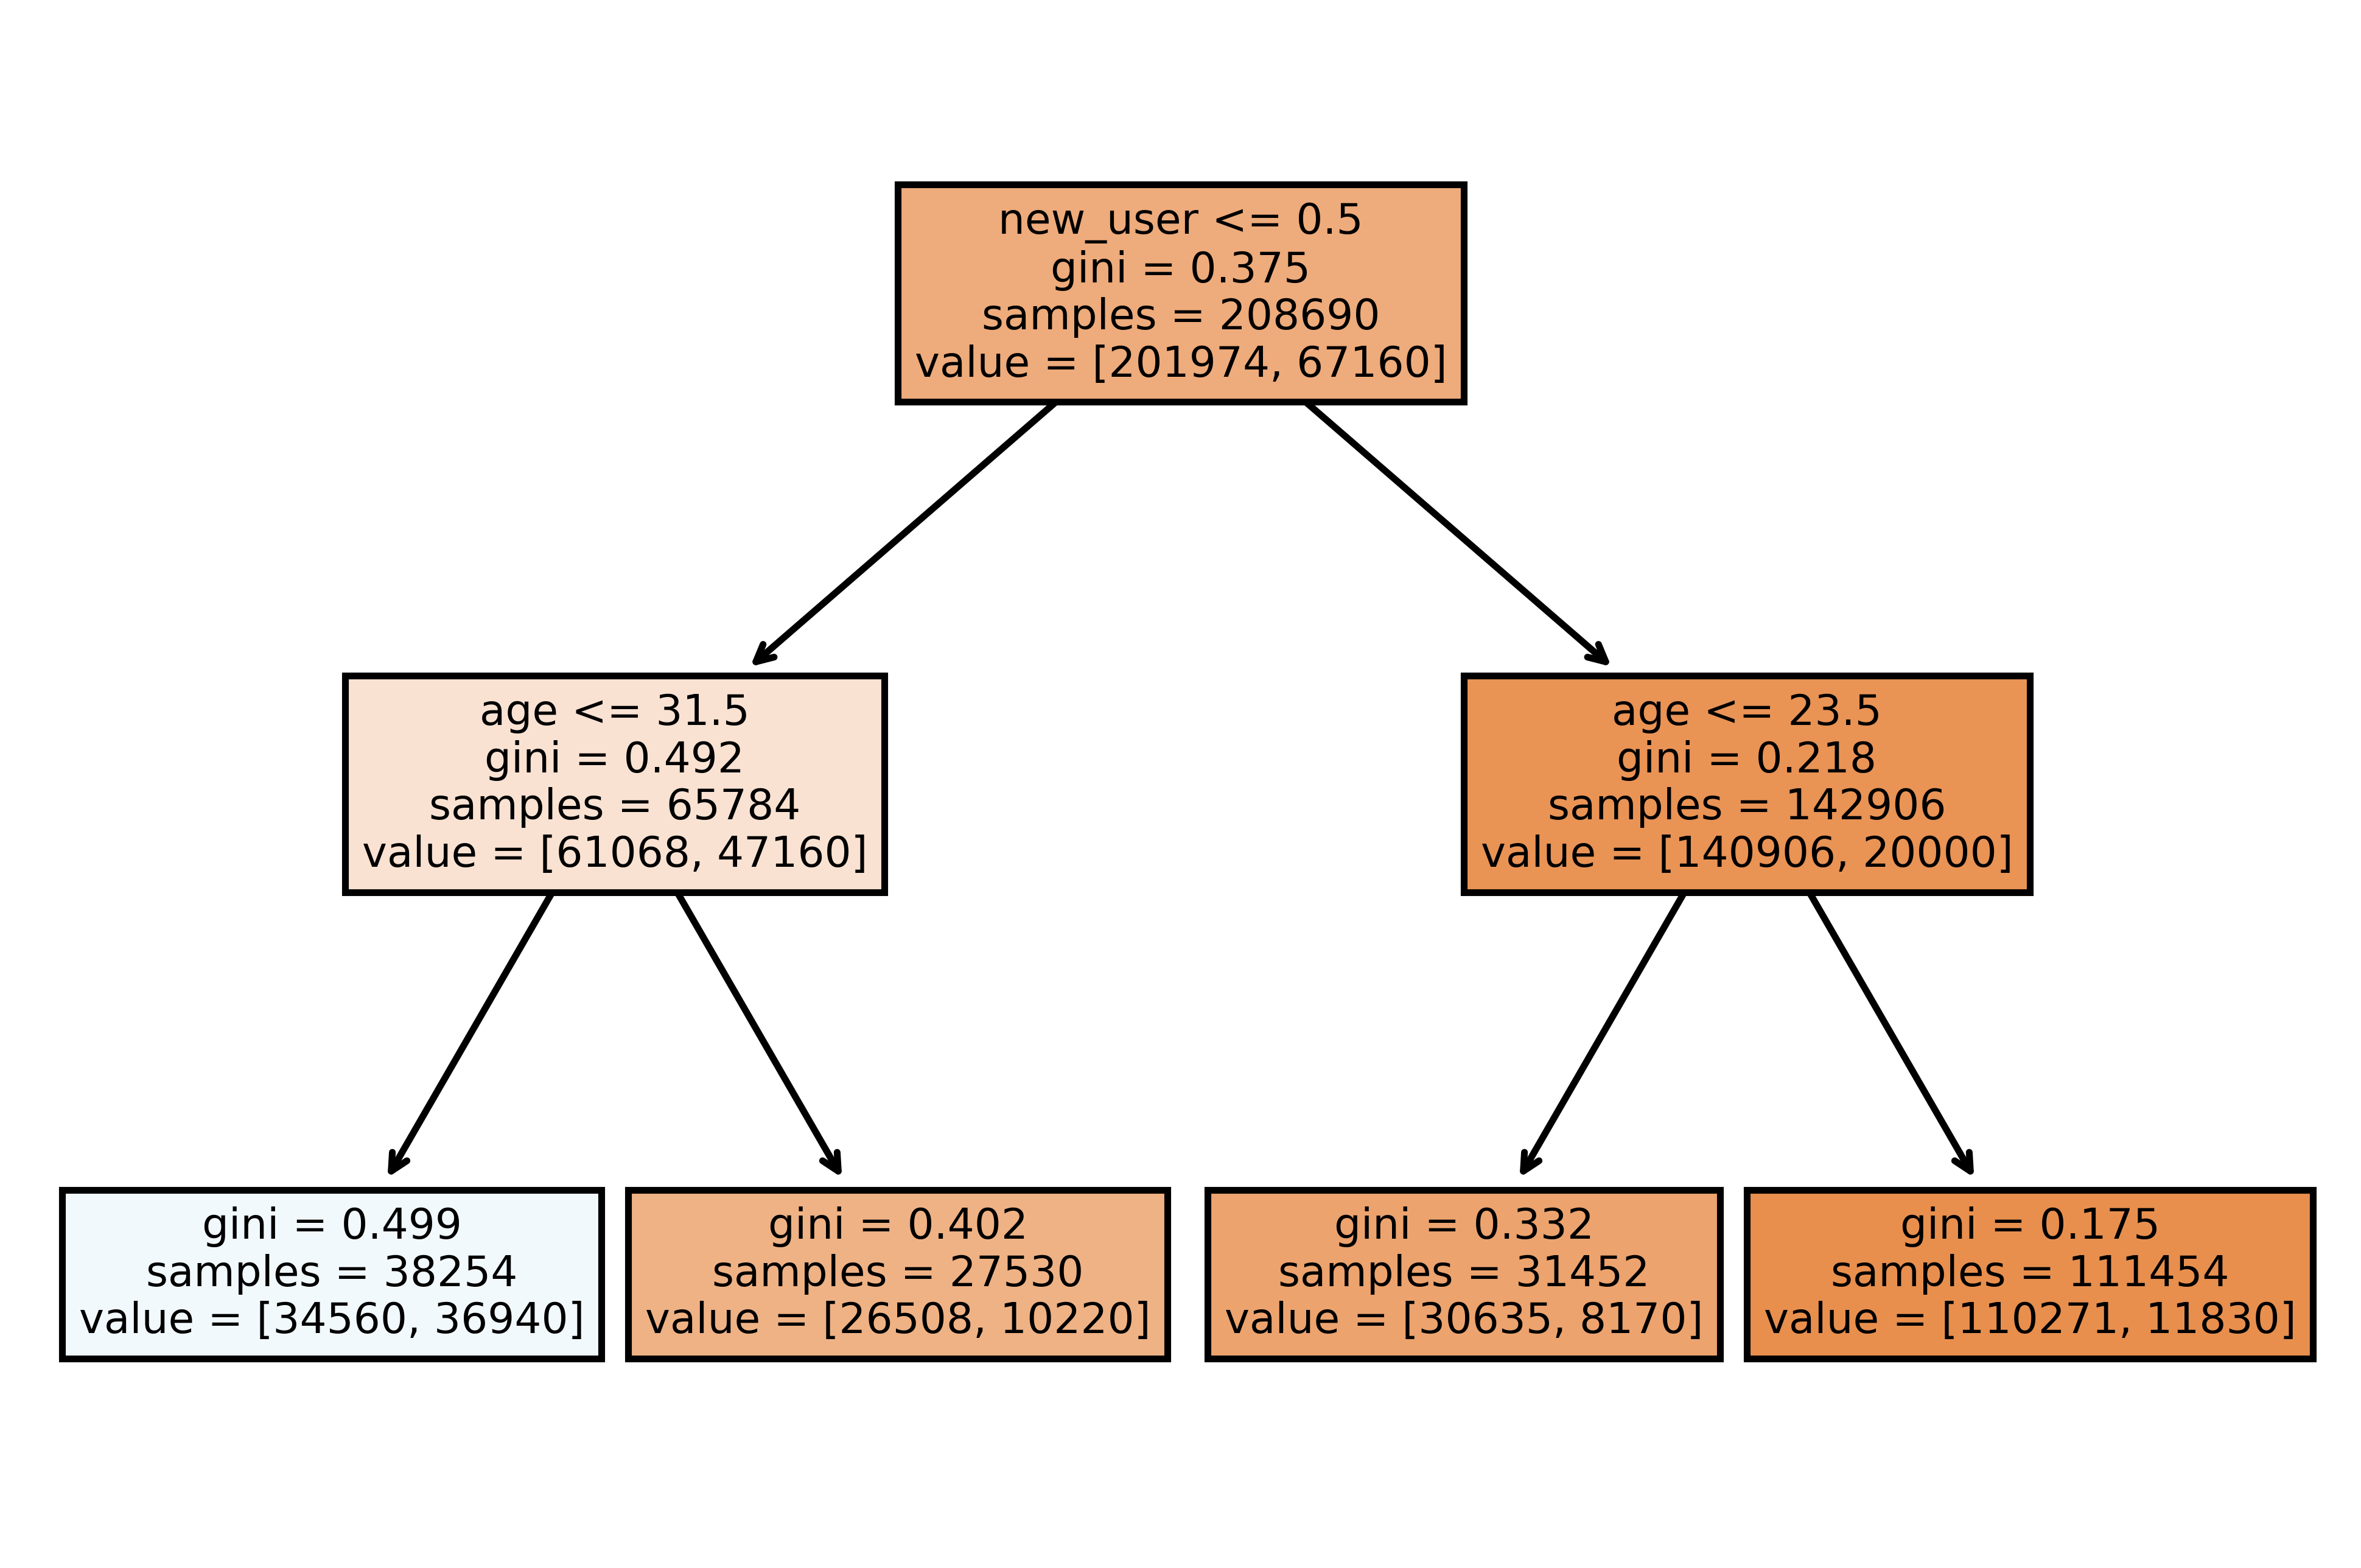

In [24]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(max_depth=2, class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
dtc.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

fig, axes = plt.subplots(nrows=1, ncols=1, dpi=800)
tree.plot_tree(dtc,
               impurity = True,
               filled = True,
               feature_names = train.drop(['converted', 'total_pages_visited'], axis=1).columns)

## Conclusions and next steps
* The site has a high conversion rate for younger users. Marketing team could advertise and use channels that are more likely to reach younger people.
* The site has a low converion rate for older users. Maybe go through UI to find out why conversion rate starts dropping significantly from 30 years old. An actionable metric is conversion rate for people >=30 yr old.
* The site has a high conversion rate in Germany although there are fewer users in Germany than in other countries. Marketing team could get more users in Germany.
* The site has a low conversion rate in China. Something might be wrong with the Chinese version of the site (ex. poorly translated, payment issue, etc). Given the large number of users in China, fixing this could improve conversion rate.
* The site has a high conversion rate for users with old accounts. Marketing team could send out targeted emails with offers to bring those users back.